# Global (Imports, Constants, Utils etc) 



## GPU type

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Mar 13 02:53:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.103.01   Driver Version: 470.103.01   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 32%   32C    P5    19W / 170W |    777MiB / 12045MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Module & Goggle Drive import

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/drive')
  !pip install keras_tuner
except:
  pass

In [ ]:
import os
import sys
import tensorflow as tf
import tensorflow.keras as keras
import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import trange, tqdm
from pickle import (
    dump,
    load
)

from tensorflow.keras import (
    layers,
    Model,
    Sequential,
    optimizers
)
from tensorflow.keras.preprocessing.sequence import (
    pad_sequences    
)

from pprint import pprint
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer


## Constant definision

In [ ]:
# If runs on google colab or not
try:
  import google.colab
  BASE_DIR = "/content/drive/MyDrive/Colab Notebooks/drone_research"
except:
  BASE_DIR = "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps"

DATA_FOLDER_NAME = "data"
DATA_FOLDER_PATH = os.path.join(BASE_DIR, DATA_FOLDER_NAME)
MODELS_FOLDER_NAME = "models"
MODELS_FOLDER_PATH = os.path.join(BASE_DIR, MODELS_FOLDER_NAME)
TUNERS_FOLDER_NAME = "tuners"
TUNERS_FOLDER_PATH = os.path.join(BASE_DIR, TUNERS_FOLDER_NAME)


OUTPUT_DATA_COLUMNS = ["position_x", "position_y", "position_z"]
TIMESTAMP_COLUMNS = [
    "motor_state_timestamp",
    "barometer_timestamp",
    "magnetometer_timestamp",
    "rotor_timestamp"
]



INPUT_SEQUENCE_COLUMNS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z",
                          "orientation_x", "orientation_y", "orientation_z", "orientation_w", "motor_state_timestamp",
                          "barometer_altitude", "barometer_pressure", 
                          "barometer_qnh", 
                          "barometer_timestamp",                          
                          "magnetometer_magnetic_field_body_x", "magnetometer_magnetic_field_body_y",
                          "magnetometer_magnetic_field_body_z", "magnetometer_timestamp",
                          "rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                          "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                          "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                          "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler",
                          "rotor_timestamp"
                         ]

ACCELOMETER_SENSORS = ["angular_acceleration_x", "angular_acceleration_y", "angular_acceleration_z",
                          "linear_acceleration_x", "linear_acceleration_y", "linear_acceleration_z",
                          "angular_velocity_x", "angular_velocity_y", "angular_velocity_z"]
ORIENTATION_SENSORS = ["orientation_x", "orientation_y", "orientation_z", "orientation_w"]
MAGNOMETER_SENSORS = ["magnetometer_magnetic_field_body_x", 
                      "magnetometer_magnetic_field_body_y",
                      "magnetometer_magnetic_field_body_z"]
BAROMETER_SENSORS = ["barometer_altitude", "barometer_pressure", "barometer_qnh"]
ROTOR_SENSORS = ["rotor_a_speed", "rotor_a_thrust", "rotor_a_torque_scaler",
                 "rotor_b_speed", "rotor_b_thrust", "rotor_b_torque_scaler",
                 "rotor_c_speed", "rotor_c_thrust", "rotor_c_torque_scaler",
                 "rotor_d_speed", "rotor_d_thrust", "rotor_d_torque_scaler"]

OUTPUT_SEQUENCE_COLUMNS = ["linear_velocity_x", "linear_velocity_y", "linear_velocity_z"]

MAIN_TIMESTAMP_COLUMN = "motor_state_timestamp"
INPUT_SEQUENCE_LENGTH = 10

In [ ]:
def get_recordings_files():
    all_csv_files = os.listdir(DATA_FOLDER_PATH)

    # Orders the "manual" files to the end (They are more likely represent 
    # the test user). So this data should be used as test
    auto_genereted_flights = [recording_file for recording_file in all_csv_files 
                              if not recording_file.startswith("manual")]
    manual_generated_flights = [recording_file for recording_file in all_csv_files 
                              if recording_file.startswith("manual")]

    all_csv_files = []
    all_csv_files.extend(auto_genereted_flights)
    all_csv_files.extend(manual_generated_flights)

    return all_csv_files


In [ ]:
# Set float 64
tf.keras.backend.set_floatx('float32')

## Utils


###General

In [ ]:
def get_feature_indexes(features: list):
  """
  Returns indexes of the input feature in the dataset
  """
  return [INPUT_SEQUENCE_COLUMNS.index(feature) for feature in features]

### Save and Load models

In [ ]:
def save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "wb") as file:
        dump(model, file)

    with open(scaler_x_file_path, "wb") as file:
        dump(scaler_x, file)

    with open(scaler_y_file_path, "wb") as file:
        dump(scaler_y, file)
        
def load_model_with_scalers_binary(model_name: str):
    """
    Saves models with the x, y scaler objects to a binary library using pickle library
    """
    model_file_name = f"{model_name}_model.pkl"
    model_file_path = os.path.join(MODELS_FOLDER_PATH, model_file_name)
    scaler_x_file_name = f"{model_name}_scaler_x.pkl"
    scaler_x_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_x_file_name)
    scaler_y_file_name = f"{model_name}_scaler_y.pkl"
    scaler_y_file_path = os.path.join(MODELS_FOLDER_PATH, scaler_y_file_name)

    with open(model_file_path, "rb") as file:
        model = load(file)

    with open(scaler_x_file_path, "rb") as file:
        scaler_x = load(file)

    with open(scaler_y_file_path, "rb") as file:
        scaler_y = load(file)

    return model, scaler_x, scaler_y

### Data Split

In [ ]:
def split_data(data: np.array, train_per = 0.95, dev_per= 0.5):
    """
    Splits data into train, dev and test
    :return:
    """
    data_len = len(data)

    train, dev, test = np.split(data, [int(train_per * data_len),
                                       int((dev_per + train_per) * data_len)])

    return train, dev, test


### Shuffle dataset

In [ ]:
def shuffle_data_set(x_data: np.array, y_data: np.array):
    example_amount = x_data.shape[0]
    shuffle_indexes = np.random.permutation(example_amount)
    
    x_data = x_data[shuffle_indexes]
    y_data = y_data[shuffle_indexes]

    return x_data, y_data

# Data Preprocessing

### Load data 

In [ ]:
# Loads data from recording file
# Converts timestamp -> time offset from last timestamp
#          location  -> step made from last location in x time offset

def _convert_timestamp_to_interval_seconds(flight_input_df: pd.DataFrame, timestamp_columns: list):
    """
    Converts the timestamp fields into the amount of seconds between each two timestamps

    Note: each timestamp represents the amount eof NANO seconds (1,000,000,000 nanoseconds = 1 seconds)
    """
    # Converts the start time to time interval
    next_time_df = flight_input_df[timestamp_columns].shift(-1)
    time_diff_df = (next_time_df - flight_input_df[timestamp_columns]) / 1_000_000_000
    flight_input_df.loc[:, timestamp_columns] = time_diff_df
    return flight_input_df

def _convert_speed_to_step(flight_output_df: pd.DataFrame):
    next_speed_df = flight_output_df.shift(-1)
    speed_diff = flight_output_df - next_speed_df

    return speed_diff
    
def load_flight_steps_from_file(csv_name: str, input_columns: list, output_columns: list):
    """

    @param csv_name:
    @param input_columns:
    @param output_columns:
    @return:
    """
    if not csv_name.endswith("csv"):
        raise ValueError(f"File with unsupported extension, expected csv (file: {csv_name})")

    csv_path = os.path.join(DATA_FOLDER_PATH, csv_name)
    flight_df = pd.read_csv(csv_path)

    x_df = flight_df[input_columns].copy()
    timestamp_columns = [column for column in input_columns if column in TIMESTAMP_COLUMNS]
    x_df = _convert_timestamp_to_interval_seconds(x_df, timestamp_columns)

    y_df = flight_df[output_columns].copy()
    y_df = _convert_speed_to_step(y_df)
    
    # Drops the last record because the process is based of difference
    x_df.drop(x_df.tail(1).index, inplace=True)
    y_df.drop(y_df.tail(1).index, inplace=True)

    return x_df, y_df

In [ ]:

def load_dataset_sequences(input_columns: list, output_columns: list):
    """
    Loads flight steps and orders it to sequences of sequence_length length.
    In order to feed it to rnn/lstm s2s model

    @param input_columns: The input columns
    @param output_columns: The outputs columns
    @return:
    """
    all_csv_files = get_recordings_files()

    # x, y data from all flight sessions
    x_sessions = []
    y_sessions = []

    for csv_name in all_csv_files:
        try:
            x_df, y_df = load_flight_steps_from_file(csv_name, input_columns, output_columns)

            x_sessions.append(x_df.to_numpy())
            y_sessions.append(y_df.to_numpy())

        except ValueError as error:
            print(str(error))

   
    # Chooses the sequence size to train on
    sequence_size = int(np.mean(np.array([len(recording) for recording in x_sessions])))
    print(f"Padds input data to {sequence_size} length")

    padded_x_sessions = pad_sequences(x_sessions, maxlen=sequence_size, 
                                      truncating="post", padding="pre",
                                      dtype='float32')
    padded_y_sessions = pad_sequences(y_sessions, maxlen=sequence_size, 
                                      truncating="post", padding="pre",
                                      dtype='float32')
    
    x_data = np.stack(padded_x_sessions)
    y_data = np.stack(padded_y_sessions)

    # y_data = np.add.accumulate(y_data, axis=1)
    return x_data, y_data

### Preprocesses data


In [ ]:
def preprocess_dataset(x_data, y_data):
    scaler_x = ColumnTransformer([
          ("rotor_sensors", StandardScaler(), get_feature_indexes(
                                            ["rotor_a_speed", "rotor_b_speed",
                                             "rotor_c_speed", "rotor_d_speed"])),
          ("accelerator_values", MinMaxScaler((-1,1)), get_feature_indexes(ACCELOMETER_SENSORS)),
          ("orientation", MinMaxScaler((-1,1)), get_feature_indexes(ORIENTATION_SENSORS)),
          ("barometer", MinMaxScaler(), get_feature_indexes(BAROMETER_SENSORS)),
          ("magnetometer_x_y", MinMaxScaler((-1,1)),get_feature_indexes
                                           (["magnetometer_magnetic_field_body_x", 
                                             "magnetometer_magnetic_field_body_y"])),
          ("magnetometer_z", MinMaxScaler(),get_feature_indexes(
                                            ["magnetometer_magnetic_field_body_z"])),                      
          ("rotors_other", MinMaxScaler(),get_feature_indexes
                                         (["rotor_a_thrust", "rotor_a_torque_scaler",
                                           "rotor_b_thrust", "rotor_b_torque_scaler",
                                           "rotor_c_thrust", "rotor_c_torque_scaler",
                                           "rotor_d_thrust", "rotor_d_torque_scaler",])),
          ],
          remainder='passthrough')
    scaler_y = MinMaxScaler()
    
    reshaped_x = x_data.reshape(-1, x_data.shape[-1])
    reshaped_y = y_data.reshape(-1, y_data.shape[-1])

    x_data = scaler_x.fit_transform(reshaped_x).reshape(x_data.shape)
    y_data = scaler_y.fit_transform(reshaped_y).reshape(y_data.shape)

    return x_data, y_data, scaler_x, scaler_y

In [ ]:
def load_preprocessed_sequence_dataset(input_columns: list, output_columns: list):
    """
    Loads the whole dataset with preprocessing

    @param input_columns: Input columns names
    @param output_columns: Output columns names
    @param sequence_length: The size of input x sequence
    @return: Loaded, preprocessed, shuffled, splitted data set
    """
    x_data, y_data = load_dataset_sequences(input_columns, output_columns)
    x_data, y_data, scaler_x, scaler_y = preprocess_dataset(x_data, y_data)

    train_x, dev_x, test_x = split_data(x_data, train_per=0.9, dev_per=0.1)
    train_y, dev_y, test_y = split_data(y_data, train_per=0.9, dev_per=0.1)
    
    return train_x, train_y, dev_x, dev_y, scaler_x, scaler_y

#Model creation and training 

In [ ]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_sequence_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)


Padds input data to 4242 length


In [ ]:
def create_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    input_layer = layers.Input(shape=(None, input_columns_amount))
    layer = layers.LSTM(32, return_sequences=True, dropout=0.05)(input_layer)
    output_layer = layers.Dense(output_columns_amount, activation="softmax")(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.01))

    return model

def create_tuned_model(input_columns_amount: int, output_columns_amount: int) -> Model:
    """
    Creates LSTM model
    @return:
    """
    input_layer = layers.Input(shape=(None, input_columns_amount))
    layer = layers.LSTM(512, return_sequences=True, dropout=0.4)(input_layer)
    layer = layers.LSTM(16, return_sequences=True)(layer)
    layer = layers.Dense(16)(layer)
    output_layer = layers.Dense(output_columns_amount)(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.005))

    return model

In [ ]:
model = create_tuned_model(len(INPUT_SEQUENCE_COLUMNS), len(OUTPUT_SEQUENCE_COLUMNS))

history = model.fit(train_x,
          train_y,
          epochs=50,
          batch_size=10,
          validation_data=(dev_x, dev_y))

2022-03-13 02:54:24.560561: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 02:54:24.567702: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 02:54:24.568413: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 02:54:24.569549: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Epoch 1/50


2022-03-13 02:54:27.164483: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8100
2022-03-13 02:54:27.761211: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


14/14 [==============================] - 8s 399ms/step - loss: 0.1481 - val_loss: 0.0090
Epoch 2/50
14/14 [==============================] - 5s 374ms/step - loss: 0.0034 - val_loss: 0.0032
Epoch 3/50
14/14 [==============================] - 5s 377ms/step - loss: 9.5717e-04 - val_loss: 0.0027
Epoch 4/50
14/14 [==============================] - 5s 375ms/step - loss: 6.0190e-04 - val_loss: 0.0025
Epoch 5/50
14/14 [==============================] - 5s 377ms/step - loss: 4.9868e-04 - val_loss: 0.0024
Epoch 6/50
14/14 [==============================] - 5s 376ms/step - loss: 4.7338e-04 - val_loss: 0.0024
Epoch 7/50
14/14 [==============================] - 5s 376ms/step - loss: 4.5632e-04 - val_loss: 0.0024
Epoch 8/50
14/14 [==============================] - 5s 379ms/step - loss: 4.4253e-04 - val_loss: 0.0024
Epoch 9/50
14/14 [==============================] - 5s 381ms/step - loss: 4.2833e-04 - val_loss: 0.0024
Epoch 10/50
14/14 [==============================] - 5s 385ms/step - loss: 4.1295e-

KeyboardInterrupt: ignored

## Loss graph

In [ ]:
loss = history.history["loss"]
val_loss = history.history["val_loss"]

plt.plot(loss)
plt.plot(val_loss)

## Save model

In [ ]:
model_name = "s2s_1Feb_5"
save_model_with_scalers_binary(model, scaler_x, scaler_y, model_name)

# Model prediction and testing - short sequences

In [ ]:
def test_lstm_model_predictions(model_name: str,
                                data_csv_name: str,
                                input_columns: list,
                                output_columns: list):
    flight_x_df, flight_y_df = load_flight_steps_from_file(data_csv_name, input_columns, output_columns)
    data_x = flight_x_df.to_numpy()
    real_y = flight_y_df.to_numpy()

    try:
        model, scaler_x, scaler_y = load_model_with_scalers_binary(model_name)
    except FileNotFoundError:
        print(f"There is no model with name: {model_name}")
        return

    noramlized_real_x = scaler_x.transform(data_x)
    normalized_real_x = np.expand_dims(noramlized_real_x, axis=0)

    predicted_sequence = model.predict(normalized_real_x)
    predicted_values = predicted_sequence[0]
    predicted_values = scaler_y.inverse_transform(predicted_sequence[0])
    
    predicted_offset = np.add.accumulate(predicted_values)
    real_offset = np.add.accumulate(real_y)
         
    
    # predicted_offset = predicted_values
    # real_offset = real_y   

    time_intervals = flight_x_df[MAIN_TIMESTAMP_COLUMN].to_numpy().reshape(-1, 1)
    time_offset = np.add.accumulate(time_intervals)
    
    return predicted_offset, real_offset

In [ ]:
predicted_offset, real_offset = test_lstm_model_predictions("s2s_1Feb_5",
                                                            "recording_30Jan_22:08_1_record.csv",
                                                            INPUT_SEQUENCE_COLUMNS,
                                                            OUTPUT_SEQUENCE_COLUMNS)

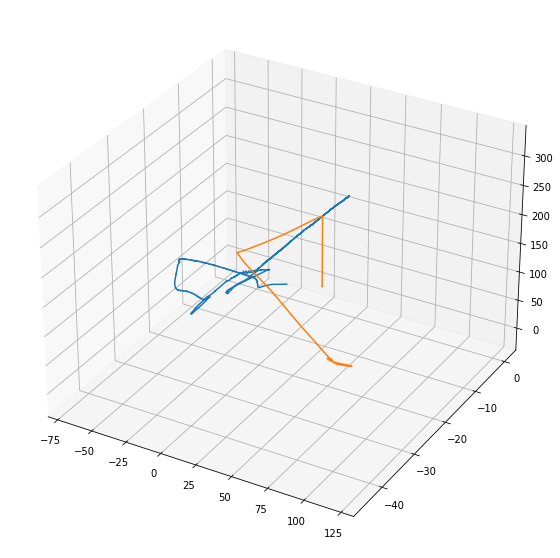

In [ ]:
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt


x_real = real_offset[:,0]
y_real = real_offset[:,1]
z_real = real_offset[:,2]

x_pred = predicted_offset[:,0]
y_pred = predicted_offset[:,1]
z_pred = predicted_offset[:,2]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')

ax.plot(x_pred,y_pred,z_pred)
ax.plot(x_real,y_real,z_real)

plt.show()

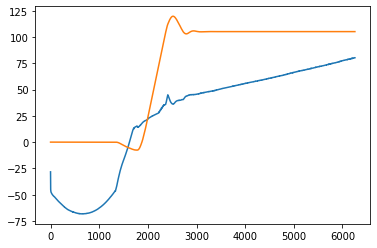

In [ ]:
plt.plot(predicted_offset[:,0])
plt.plot(real_offset[:, 0])

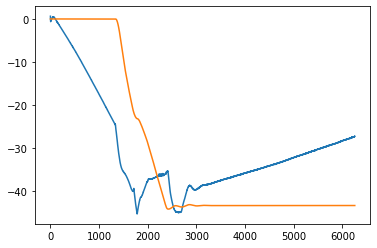

In [ ]:
plt.plot(predicted_offset[:,1])
plt.plot(real_offset[:, 1])

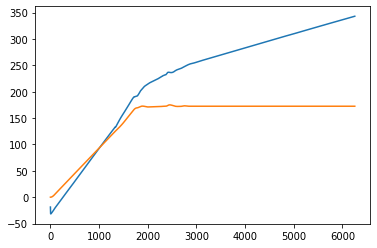

In [ ]:
plt.plot(predicted_offset[:,2])
plt.plot(real_offset[:, 2])

# Hyperparameters tuning

## Model Creation

In [ ]:
def create_dynamic_model(hp: kt.HyperParameters) -> Model:
    """
    Creates Sequence model dynamically
    :param hp: Hyper parameters (Initialized by a tuning algorithm)
    :return:
    """
    model = Sequential()

    lstm_layers = hp.Int(f"lstm_layers", min_value=1, max_value=3)
    for layer_id in range(lstm_layers):
        units = hp.Int(f"lstm_{layer_id}_units", min_value=16, max_value=256, step=16)
        params = {
          "dropout": hp.Float(f"lstm_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05),
          "return_sequences": True
        }
        if layer_id == 0:
            params["input_shape"] = (None, hp.get("input_columns_amount"))
        model.add(layers.LSTM(units, **params))
     

    dense_layers = hp.Int(f"dense_layers", min_value=1, max_value=3)
    dense_activation = hp.Choice("dense_activation", ["sigmoid", "relu", "tanh"])
    for layer_id in range(dense_layers):
        units = hp.Int(f"dense_{layer_id}_units", min_value=16, max_value=256, step=16)
        model.add(layers.Dense(units, activation=dense_activation))

        dropout_rate = hp.Float(f"dense_{layer_id}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
        model.add(layers.Dropout(dropout_rate))

    model.add(layers.Dense(hp.get("output_columns_amount"), activation="sigmoid"))
    learning_rate = hp.Choice("adam_learning_rate", [0.001, 0.002, 0.0005, 0.005])

    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)

    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))

    return model



In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

## The Tuner



In [ ]:
hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "s2s_13Mar22_Night_2"
tuner = kt.BayesianOptimization(
    create_dynamic_model,
    hyperparameters=hp,
    objective="val_loss",
    max_trials=5000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
    executions_per_trial = 1
)

In [ ]:
tuner.get_best_hyperparameters()[0].values

In [ ]:
tuner.get_best_models()[0]

## Truning

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
early_stop2 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, baseline=0.003)
tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 2000,
             batch_size=32,
             callbacks=[early_stop, early_stop2, tensorboard_callback]
            )



# The model - Test

In [ ]:
train_x, train_y, dev_x, dev_y, scaler_x, scaler_y = \
    load_preprocessed_sequence_dataset(INPUT_SEQUENCE_COLUMNS, OUTPUT_SEQUENCE_COLUMNS)

(152, 4242, 31)
(152, 4242, 3)


In [ ]:
from tensorflow import keras
from keras import Model
from keras.layers import (
    LSTM,
    Dense,
    Input
)

def create_model():
    input = Input(shape=(INPUT_SEQUENCE_LENGTH, len(INPUT_SEQUENCE_COLUMNS)))
    lstm, state_h, state_c = LSTM(16, return_sequences=True, return_state=True)(input)
    output = Dense(len(OUTPUT_SEQUENCE_COLUMNS))(lstm)

    model = Model(inputs=input, outputs= [output])
    model.compile(loss='mean_squared_error',
              optimizer=optimizers.Adam(learning_rate=0.01))
    
    return model


In [ ]:
print(INPUT_SEQUENCE_LENGTH)
print(len(INPUT_SEQUENCE_COLUMNS))
print(len(OUTPUT_SEQUENCE_COLUMNS))

10
32
3


In [ ]:
model = create_model()

In [ ]:
model.fit(train_x, train_y, validation_data=(dev_x, dev_y), epochs=5, batch_size=256)

Epoch 1/5
1236/1236 [==============================] - 12s 6ms/step - loss: 0.4267 - val_loss: 0.0232
Epoch 2/5
1236/1236 [==============================] - 7s 6ms/step - loss: 0.1966 - val_loss: 0.0077
Epoch 3/5
1236/1236 [==============================] - 7s 6ms/step - loss: 0.1192 - val_loss: 0.0116
Epoch 4/5
1236/1236 [==============================] - 7s 6ms/step - loss: 0.0931 - val_loss: 0.0299
Epoch 5/5
1236/1236 [==============================] - 7s 6ms/step - loss: 0.0807 - val_loss: 0.0079


## Trainable model 

In [ ]:

def create_model_dynamic(hp: kt.HyperParameters) -> Model:
    """
    Creates LSTM model using the input hyperparameters chose by keras_tuner
    """
    input_layer = layers.Input(shape=(None, hp.get("input_columns_amount")))
    lstm_layer_1_units = hp.Int("lstm_layer_1_units", min_value=8, max_value=256, step=8)
    layer = layers.LSTM(lstm_layer_1_units, return_sequences=True)(input_layer)
    output_layer = layers.Dense(hp.get("output_columns_amount"))(layer)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=0.001, clipvalue=.5))

    return model

def _create_regulator(hp: kt.HyperParameters, layer_name: str):
    regulator_type = kernels = hp.Choice(f"{layer_name}_regulator_type", values=["l1", "l2"])
    kernels = hp.Choice("{layer_name}_regulator_kernel", values=[0.01,0.001,0.1,0.005,0.05])
    if regulator_type == "l1":
        return tf.keras.regularizers.l1(kernels)
    return tf.keras.regularizers.l2(kernels)
        
 
def create_model_dynamic(hp: kt.HyperParameters) -> Model:
    """
    Creates LSTM model using the input hyperparameters chose by keras_tuner
    """

    input_layer = layers.Input(shape=(None, hp.get("input_columns_amount")))
    
    lstm_layer_1_units = hp.Int("lstm_layer_units", min_value=32, max_value=256, step=1)
    lstm_props = {}
    if hp.Boolean(f"lstm_regulator"):
        lstm_props["kernel_regularizer"] = _create_regulator(hp, "lstm")
        
    layer = layers.LSTM(lstm_layer_1_units, return_sequences=True, **lstm_props)(input_layer)
    if hp.Boolean(f"lstm_dropout"):
        dropout_rate = hp.Float(f"lstm_dropout_rate", min_value=0.0, max_value=0.4, step=0.05)
        layer = layers.Dropout(dropout_rate)(layer)
    
    dense_layers = hp.Int("dense_layers_amount", min_value=0, max_value=2)
    dense_activation = hp.Choice("dense_activation", ["sigmoid", "relu", "sigmoid", "relu", "tanh"])

    for layer_index in range(1, dense_layers + 1):
        layer_name = f"dense_{layer_index}"
        units = hp.Int(f"{layer_name}_units", min_value=16, max_value=128, step=1)
        
        dense_props = {}
        if hp.Boolean(f"{layer_name}_regulator"):
            dense_props["kernel_regularizer"] = _create_regulator(hp, layer_name)
        
        layer = layers.Dense(units, activation=dense_activation, **dense_props)(layer)

        if hp.Boolean(f"dense_{layer_index}_dropout"):
            dropout_rate = hp.Float(f"dense_{layer_index}_dropout_rate", min_value=0, max_value=0.4, step=0.05)
            layer = layers.Dropout(dropout_rate)(layer)

    output_layer = layers.Dense(hp.get("output_columns_amount"))(layer)

    learning_rate = hp.Choice("adam_learning_rate", [0.1, 0.2, 0.05, 1e-2,2e-2, 1e-3,2e-3,3e-3, 5e-3, 5e-4])
    if hp.Boolean(f"learning_rate_decay"):
        learning_rate = optimizers.schedules.ExponentialDecay(
            initial_learning_rate=learning_rate,
            decay_steps=10000,
            decay_rate=0.9)
    
    model = Model(inputs=input_layer, outputs=output_layer)
    
    model.compile(loss='mean_squared_error',
                  optimizer=optimizers.Adam(learning_rate=learning_rate))
    
    return model
    

## Tuner 

In [ ]:
from settings import TUNERS_FOLDER_PATH
import copy 


hp = kt.HyperParameters()
hp.Fixed("input_columns_amount", len(INPUT_SEQUENCE_COLUMNS))
hp.Fixed("output_columns_amount", len(OUTPUT_SEQUENCE_COLUMNS))

project_name = "s2s_exp1_6Jan22"
tuner = kt.BayesianOptimization(
    create_model_dynamic,
    hyperparameters=hp,
    tune_new_entries=True,
    objective="val_loss",
    max_trials=1000,
    directory=TUNERS_FOLDER_PATH,
    project_name=project_name,
)

INFO:tensorflow:Reloading Oracle from existing project /home/israzex/Desktop/drone_homecoming_rl/artificial_gps/tuners/s2s_exp1_6Jan22/oracle.json
INFO:tensorflow:Reloading Tuner from /home/israzex/Desktop/drone_homecoming_rl/artificial_gps/tuners/s2s_exp1_6Jan22/tuner0.json


## Tuning process

In [ ]:
tensorboard_dir = os.path.join(os.path.join(TUNERS_FOLDER_PATH,project_name), "tensorboard")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=tensorboard_dir, 
                                                      histogram_freq=1)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, baseline=80)

tuner.search(train_x,
            train_y,
             validation_data=(dev_x, dev_y),
             epochs = 1000,
             batch_size=512,
             callbacks=[early_stop, tensorboard_callback])

# tuner.search(train_x,
#             train_y,
#              validation_data=(dev_x, dev_y),
#              epochs = 1000,
#              batch_size=512,
#              callbacks=[early_stop])

Trial 48 Complete [00h 10m 45s]
val_loss: 12.985352516174316

Best val_loss So Far: 8.593206405639648
Total elapsed time: 00h 10m 45s


2022-01-07 01:08:47.528086: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0xe6f7310



Search: Running Trial #49

Hyperparameter    |Value             |Best Value So Far 
input_columns_a...|32                |32                
output_columns_...|3                 |3                 
lstm_layer_units  |256               |256               
lstm_regulator    |False             |False             
lstm_dropout      |False             |True              
dense_layers_am...|0                 |0                 
dense_activation  |tanh              |tanh              
adam_learning_rate|0.0005            |0.0005            
learning_rate_d...|False             |True              
lstm_regulator_...|l1                |l2                
{layer_name}_re...|0.05              |0.05              
lstm_dropout_rate |0.4               |0.4               
dense_1_units     |128               |128               
dense_1_regulator |False             |False             
dense_1_dropout   |True              |True              
dense_2_units     |16                |16                
den

2022-01-07 01:08:50.759697: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4029849600 exceeds 10% of free system memory.


Epoch 1/1000
  5/615 [..............................] - ETA: 16s - loss: 1027.8944WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0128s vs `on_train_batch_end` time: 0.0178s). Check your callbacks.


615/615 [==============================] - 20s 32ms/step - loss: 163.2887 - val_loss: 55.0815
Epoch 2/1000
615/615 [==============================] - 18s 30ms/step - loss: 16.9773 - val_loss: 48.0848
Epoch 3/1000
615/615 [==============================] - 19s 30ms/step - loss: 14.8995 - val_loss: 46.8833
Epoch 4/1000
615/615 [==============================] - 19s 30ms/step - loss: 14.3027 - val_loss: 48.5078
Epoch 5/1000
137/615 [=====>........................] - ETA: 12s - loss: 14.2968

## Save best tuned and trained models

In [ ]:
# model = tuner.get_best_models(num_models=10)[0]
# save_model_with_scalers_binary(model, scaler_x, scaler_y, "s2s_100seq_1")

## Truning statistics

In [ ]:
# %load_ext tensorboard
# os.environ['TENSORBOARD_BINARY'] = '/home/israzex/Desktop/drone_homecoming_rl/venv/bin/tensorboard'
# %tensorboard --logdir "/home/israzex/Desktop/drone_homecoming_rl/artificial_gps/tuners/s2s_exp1_3/tensorboard"


# Tests